In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from bo_functions_generic import gen_theta_set

from CS2_bo_plotters import plot_obj_abs_min
from CS2_bo_plotters import value_plotter
from CS2_bo_plotters import plot_obj
from CS2_bo_plotters import plot_Theta
from CS2_bo_plotters import plot_Theta_min
from CS2_bo_plotters import path_name
from CS2_bo_functions_multi_dim import set_ep
from CS2_bo_plotters import plot_org_train, plot_EI_abs_max

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html

def csv_to_array(csv_path):
    """
    Turn a csv file into a numpy array so that it can be used with bo_plotters
    
    Parameters:
    -----------
        csv_path: str, path of csv you want to turn into an array
    Returns:
    --------
        csv_array: np.ndarray, array on values in the CSV file
    """
    
    csv_pd = pd.read_csv(csv_path, index_col = False)
    csv_pd.drop(columns=csv_pd.columns[0], 
        axis=1, 
        inplace=True)
    csv_array = csv_pd.to_numpy()
    
    return csv_array

In [15]:
# DateTime = "2022/10/21/13-05" #Date and Time - Dispayed in job file
DateTime = "2022/10/21/13-18" #Date and Time - Dispayed in job file
# DateTime = None

emulator = False
obj = "obj"
sparse_grid = False
sep_fact = 0.7

exp_d = 1
n = 5

param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
indecies = [list(param_dict.keys())[list(param_dict.values()).index('\\theta_1')],
            list(param_dict.keys())[list(param_dict.values()).index('\\theta_2')]]

Theta_True = np.array([1,-1])

bounds = np.array([[-2, -2],
                   [ 2,  2]])


# exp_d = 2
# n = 15 #Number of experimental data points to use

# param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
#               4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
# indecies = [list(param_dict.keys())[list(param_dict.values()).index('a_1')],
#             list(param_dict.keys())[list(param_dict.values()).index('a_2')]]

# Constants = np.array([[-200,-100,-170,15],
#                       [-1,-1,-6.5,0.7],
#                       [0,0,11,0.6],
#                       [-10,-10,-6.5,0.7],
#                       [1,0,-0.5,-1],
#                       [0,0.5,1.5,1]])

# Theta_True = Constants[1:3].flatten()

# bounds = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
#                    [ 2,  2,   0,  2,  2,  2, 15,  2]])

param_names_list = [param_dict[0], param_dict[1]] #Fill in depending on problem
mesh_combo = str(param_names_list[0]) + "-" + str(param_names_list[1])

mesh_combo = None
# run = 1
# Bo_iter = 1

run = 12
Bo_iter = 6

set_lengthscale = None
save_CSV = False

t = 20
if emulator == True:
    t = n*t

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]

#Define GP Testing space
p=20
d = len(Theta_True)


# Need to redefine to save theta_set_org 
# theta_set_org = gen_theta_set(LHS = True, n_points = p, dimensions = d, bounds = bounds)
# Theta1_lin = np.linspace(np.min(theta_set_org[:,indecies[0]]),np.max(theta_set_org[:,indecies[0]]), p)
# Theta2_lin = np.linspace(np.min(theta_set_org[:,indecies[1]]),np.max(theta_set_org[:,indecies[1]]), p)
# theta_mesh = np.array(np.meshgrid(Theta1_lin, Theta2_lin)) 

theta_mesh = gen_theta_set(LHS = False, n_points = p, dimensions = d, bounds = bounds)
theta_mesh = theta_mesh.T.reshape((2, p, p))
# print(theta_mesh.shape)
    
ep = set_ep(emulator, obj, sparse_grid)
# ep = 1

# tot_iter = bo_iters= 3 #Total Number of iters - Dispayed in job file
# tot_runs = 2 #Total Number of runs - Dispayed in job file

tot_iter = bo_iters= 100 #Total Number of iters - Dispayed in job file
tot_runs = 15 #Total Number of runs - Dispayed in job file

is_figure = False
save_figure = False

run -= 1 # run should be number you want -1
Bo_iter -= 1 #Iter you want -1

In [16]:
#Create max EI and save for old data
fxn = "value_plotter"
title_save = "EI"
title = 'E(I(\\theta))'
save_figure_EI_max = True


sep_fact_list = np.linspace(0.1,1,10)
for k in range(len(sep_fact_list)):
    max_EI = np.zeros((tot_runs,tot_iter)) #Saves ln(SSE) values
    for i in range(tot_runs):
        for j in range(tot_iter):
            try:
                path_title = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, j, title_save,
                                       i, tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, 
                                       sep_fact = sep_fact_list[k], is_figure = False, csv_end = "/" + title_save + ".csv")
                EI = csv_to_array(path_title)
                max_EI[i,j] = np.max(EI)
            except:
                max_EI[i,j] = 0

    plot_EI_abs_max(max_EI, emulator, ep, sparse_grid, set_lengthscale, t, obj, save_figure = save_figure_EI_max, 
                    tot_iter=tot_iter, tot_runs=tot_runs,DateTime=DateTime, sep_fact = sep_fact_list[k], save_CSV = True)

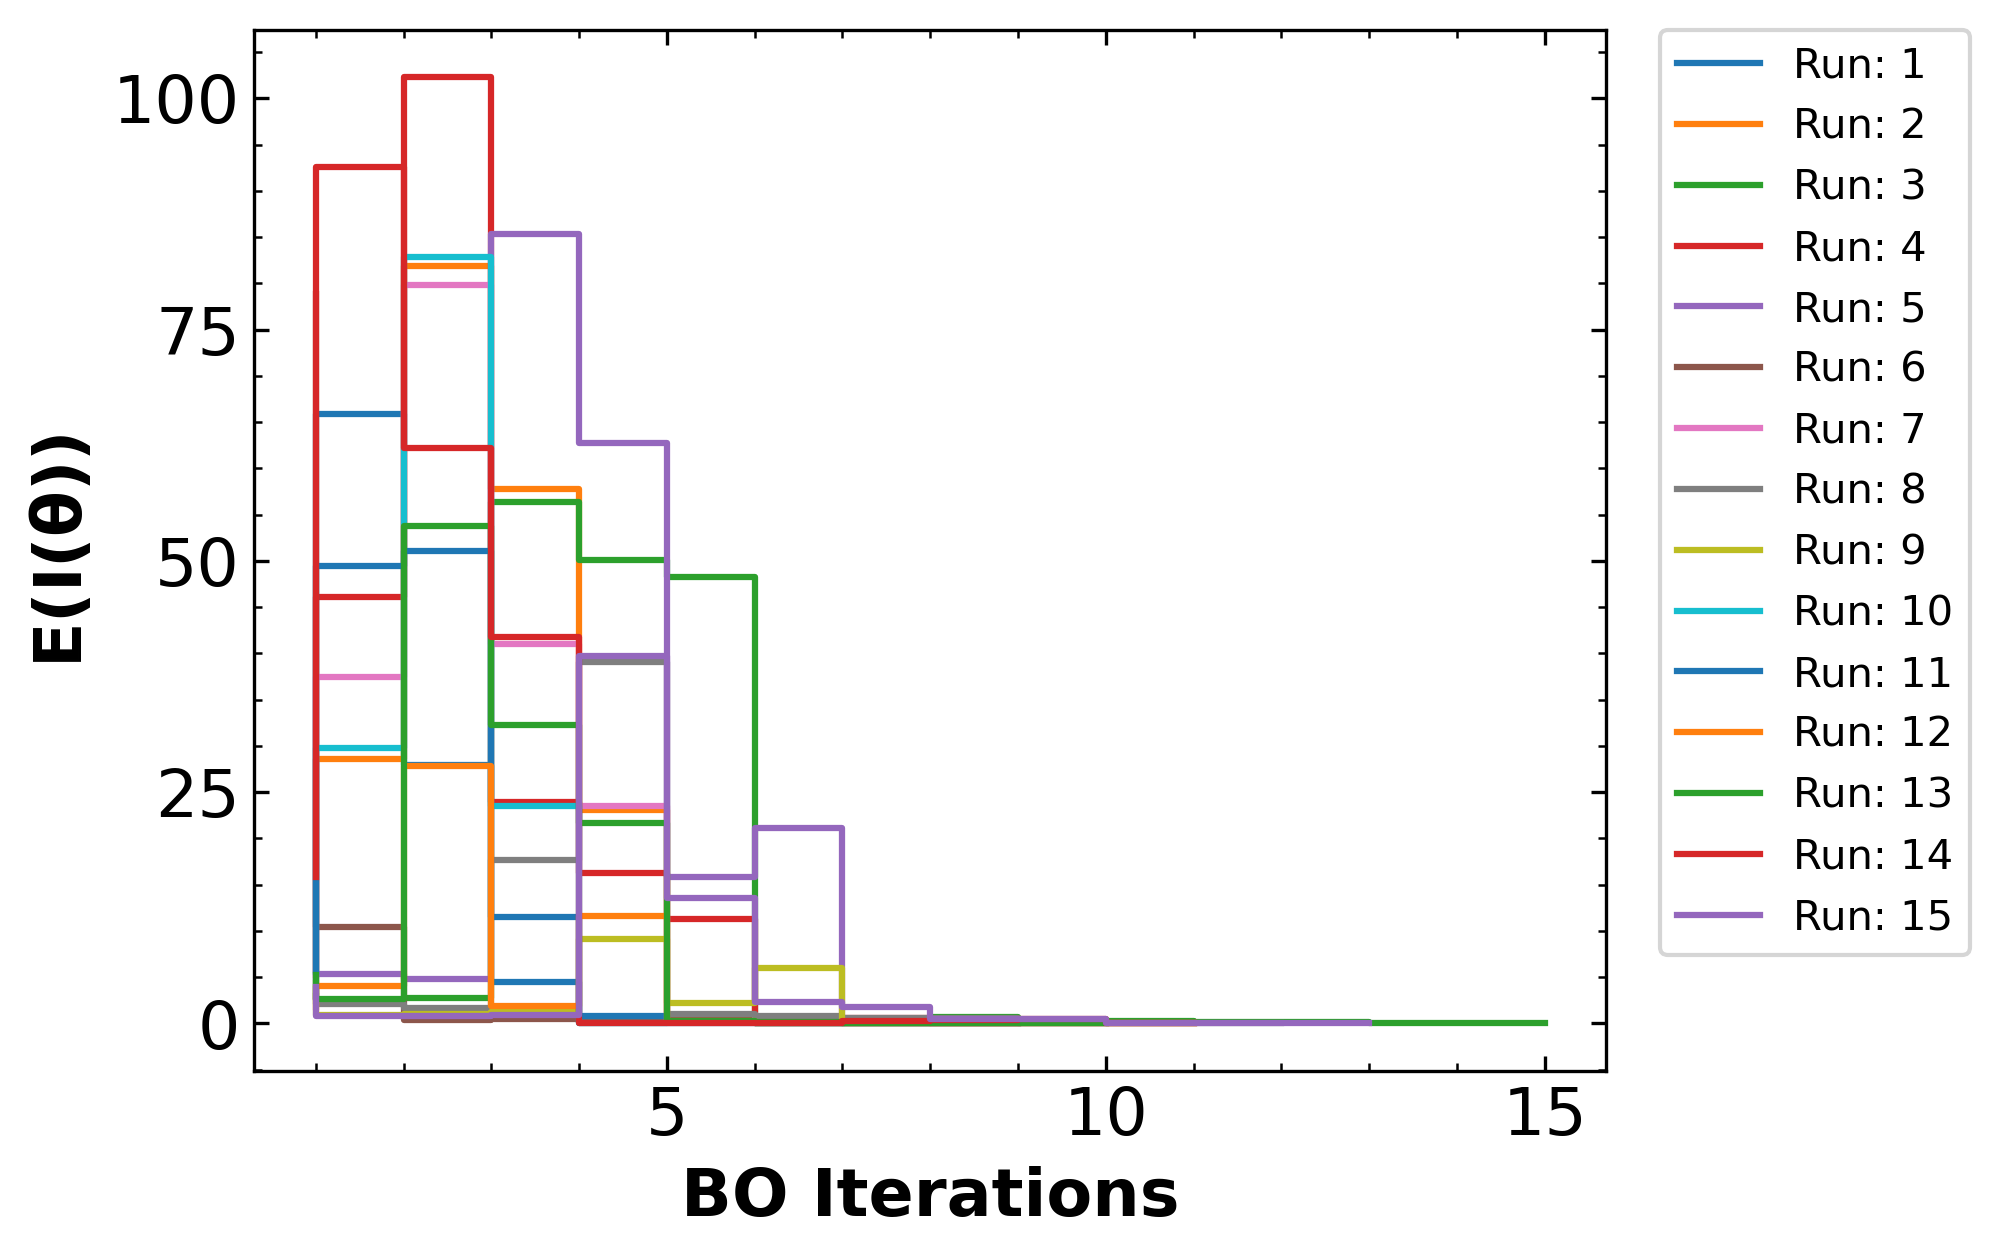

In [8]:
#WORKS
csv_end = ".npy" #For obj
fxn = "plot_EI_abs_max"

path = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo = None, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = ".npy")
# print(path)
EI_abs_max = np.load(path)
plot_EI_abs_max(EI_abs_max, emulator, ep, sparse_grid, set_lengthscale, t, obj,
                 save_figure, tot_iter, tot_runs,DateTime, sep_fact, save_CSV = save_CSV)

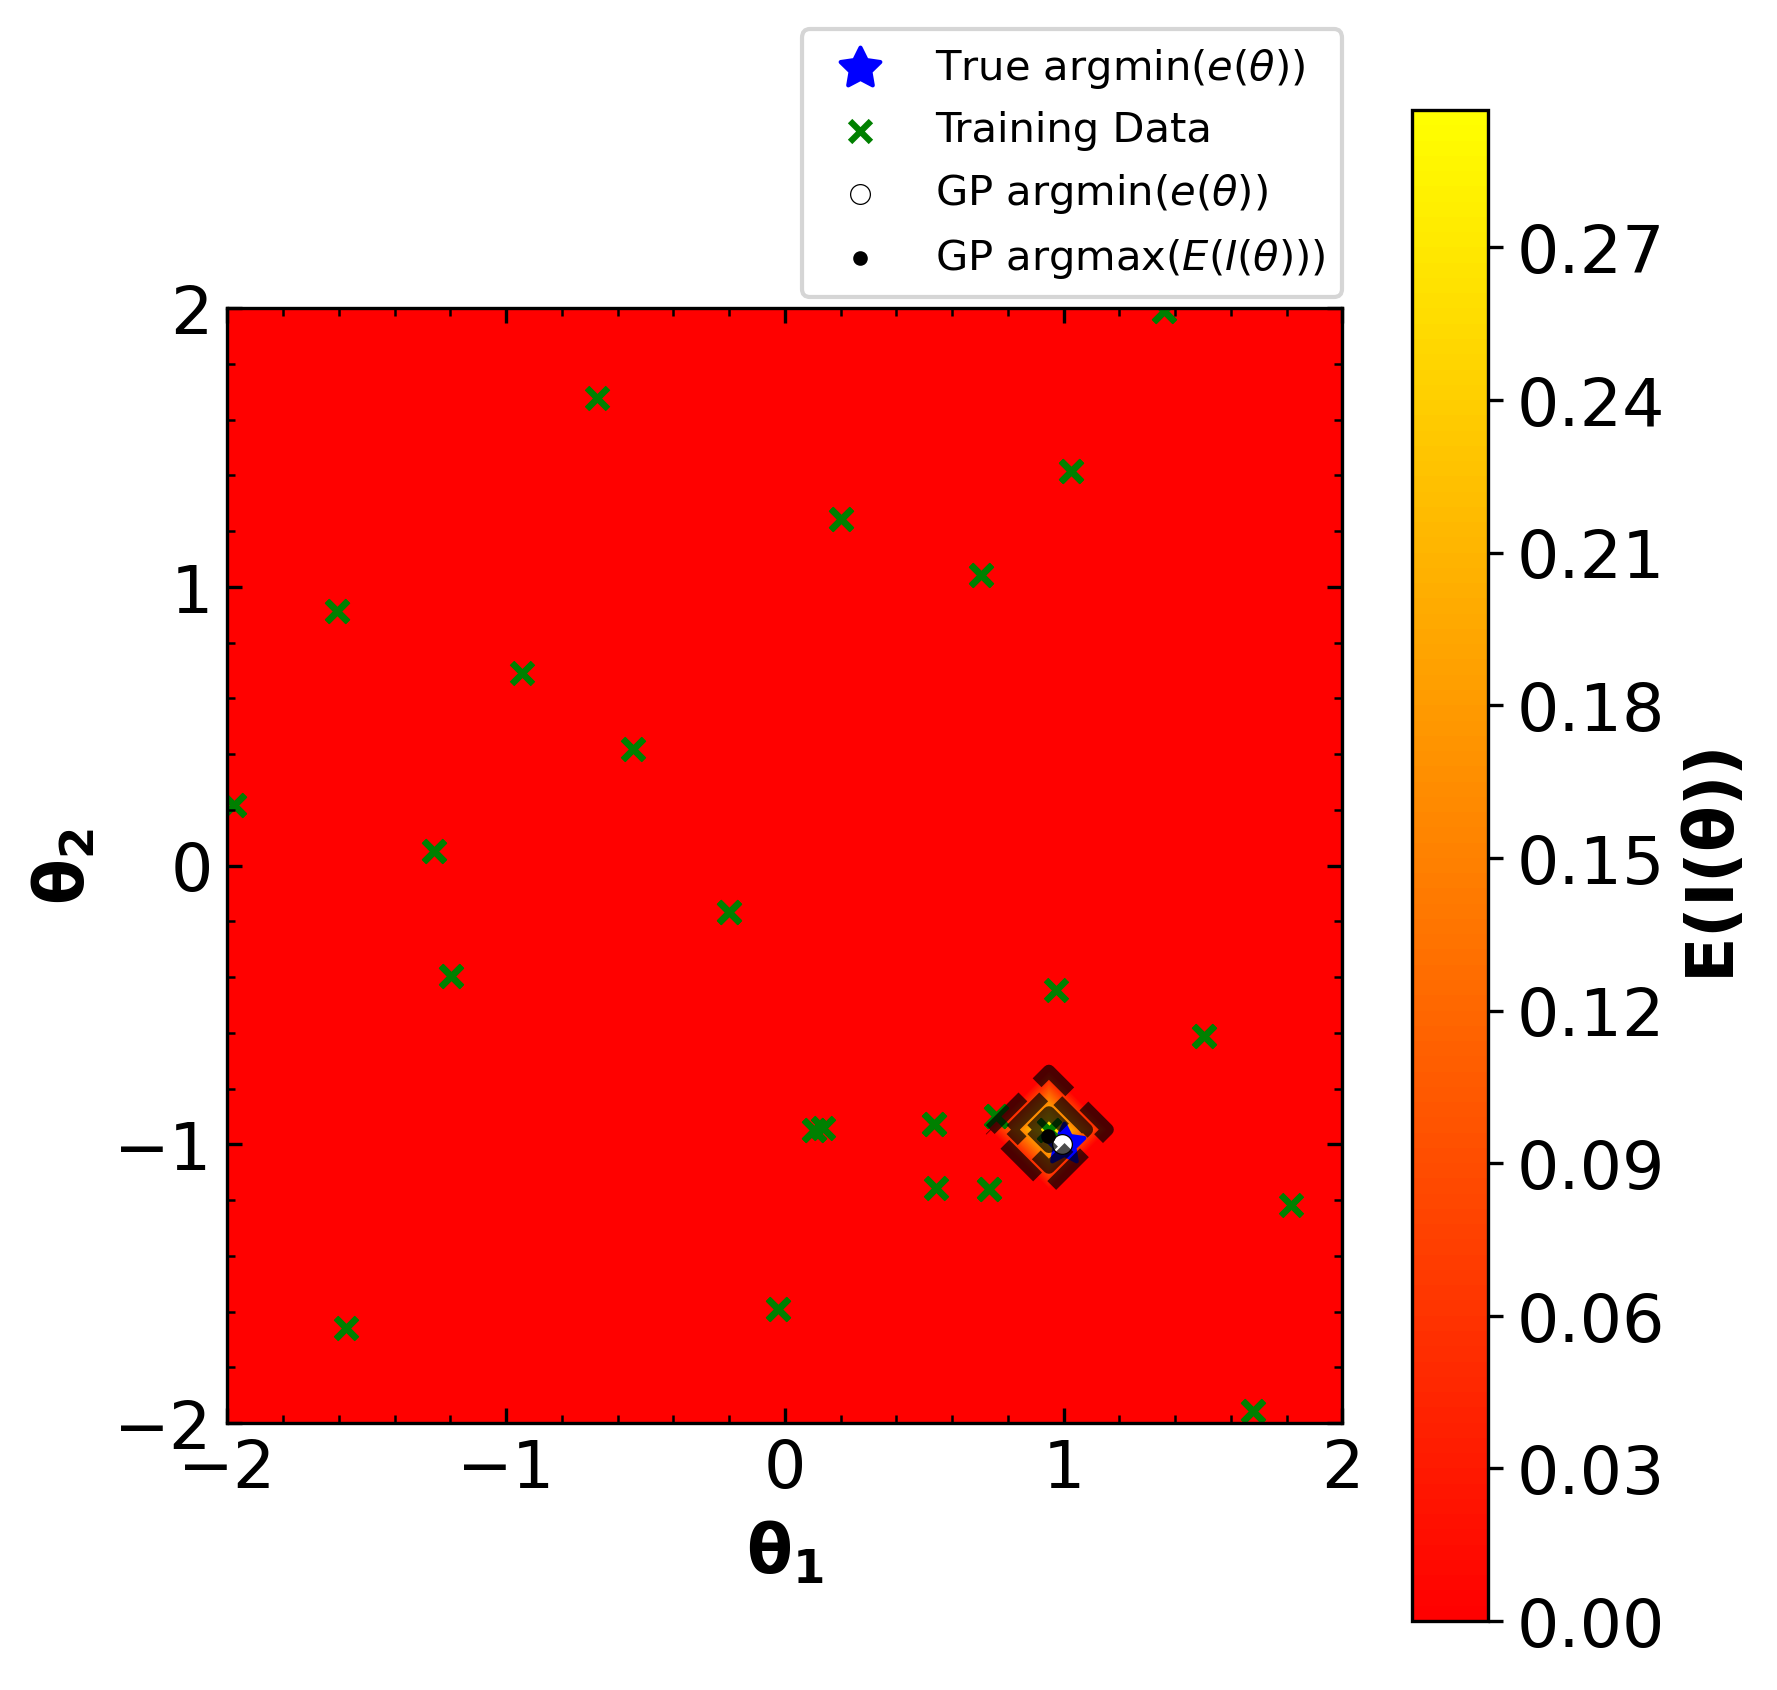

In [5]:
levels = 35

save_figure = False
# save_figure = True
# titles = ['E(I(\\theta))','log(e(\\theta))','\sigma^2','\sigma','Best_Error','z','EI_term_1','EI_term_2','CDF','PDF']  
# titles_save = ["EI","ln(SSE)","Var","StDev","Best_Error","z","ei_term_1","ei_term_2","CDF","PDF"] 

fxn = "value_plotter"

title_save = "EI"
title = 'E(I(\\theta))'
# title = 'log(E(I(\\theta)))'

# title_save = "ln(SSE)"
# title = 'log(e(\\theta))'

path_title = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + title_save + ".csv")
path_best = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + "GP_Best_EI_Pred.csv")
path_opt = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + "GP_Min_SSE_Pred.csv")
# path_true = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, Bo_iter, title_save, run, tot_iter=tot_iter, 
#           tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + "True_p.csv")

title_save_2 = "Train_Test_Data"
#Need to fix this
path_train = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, None, Bo_iter, title_save_2, run, 
                         tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, 
                         is_figure = False, csv_end = "/" + "Train_p.csv")
path_test = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, None, Bo_iter, title_save_2, run, 
                         tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, 
                         is_figure = False, csv_end = "/" + "Test_p.csv")

train_p = csv_to_array(path_train)
test_p = csv_to_array(path_test)

p_GP_best = csv_to_array(path_best)
p_GP_opt = csv_to_array(path_opt)
p_true = Theta_True

# print(p_GP_opt)
z = csv_to_array(path_title)

if title == 'log(E(I(\\theta)))':
    z = np.exp(z)

#Note need a .T here for old files but not for new ones
value_plotter(theta_mesh, z.T, p_true, p_GP_opt, p_GP_best, train_p, title,title_save, obj, ep, emulator, sparse_grid, 
              set_lengthscale, save_figure, param_names_list, Bo_iter, run = run, tot_iter = tot_iter, tot_runs = tot_runs, 
              DateTime=DateTime, t = t, sep_fact = sep_fact, levels = levels, save_CSV = save_CSV)

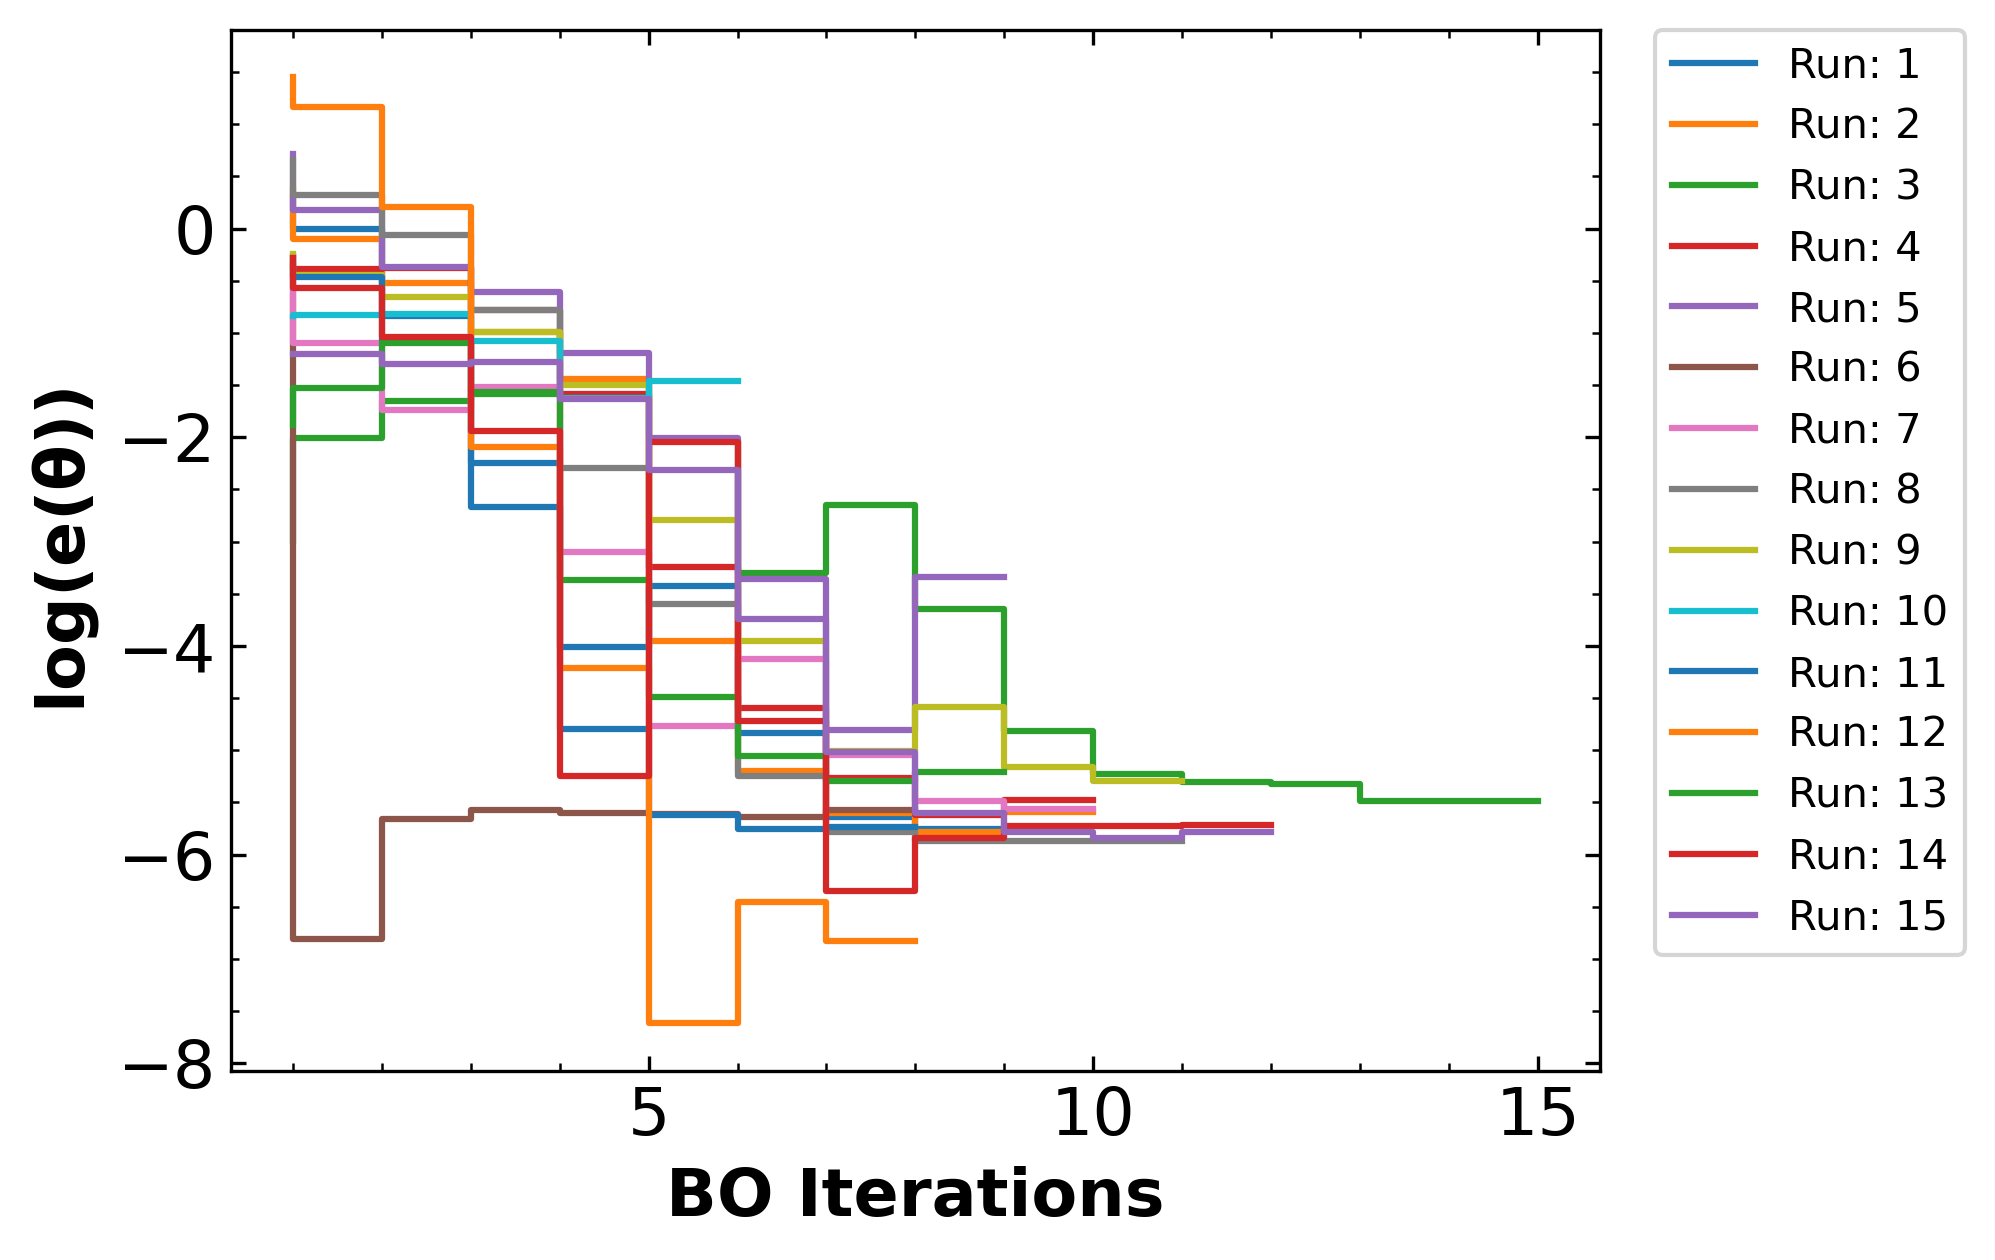

In [7]:
#WORKS
csv_end = ".csv" #For obj
fxn = "plot_obj"

path = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo = None, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = ".csv")
# print(path)
obj_array = csv_to_array(path)
# print(obj_array)
plot_obj(obj_array, t, obj, ep, emulator, sparse_grid, set_lengthscale, save_figure, tot_iter=tot_iter, 
         tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, save_CSV = save_CSV)

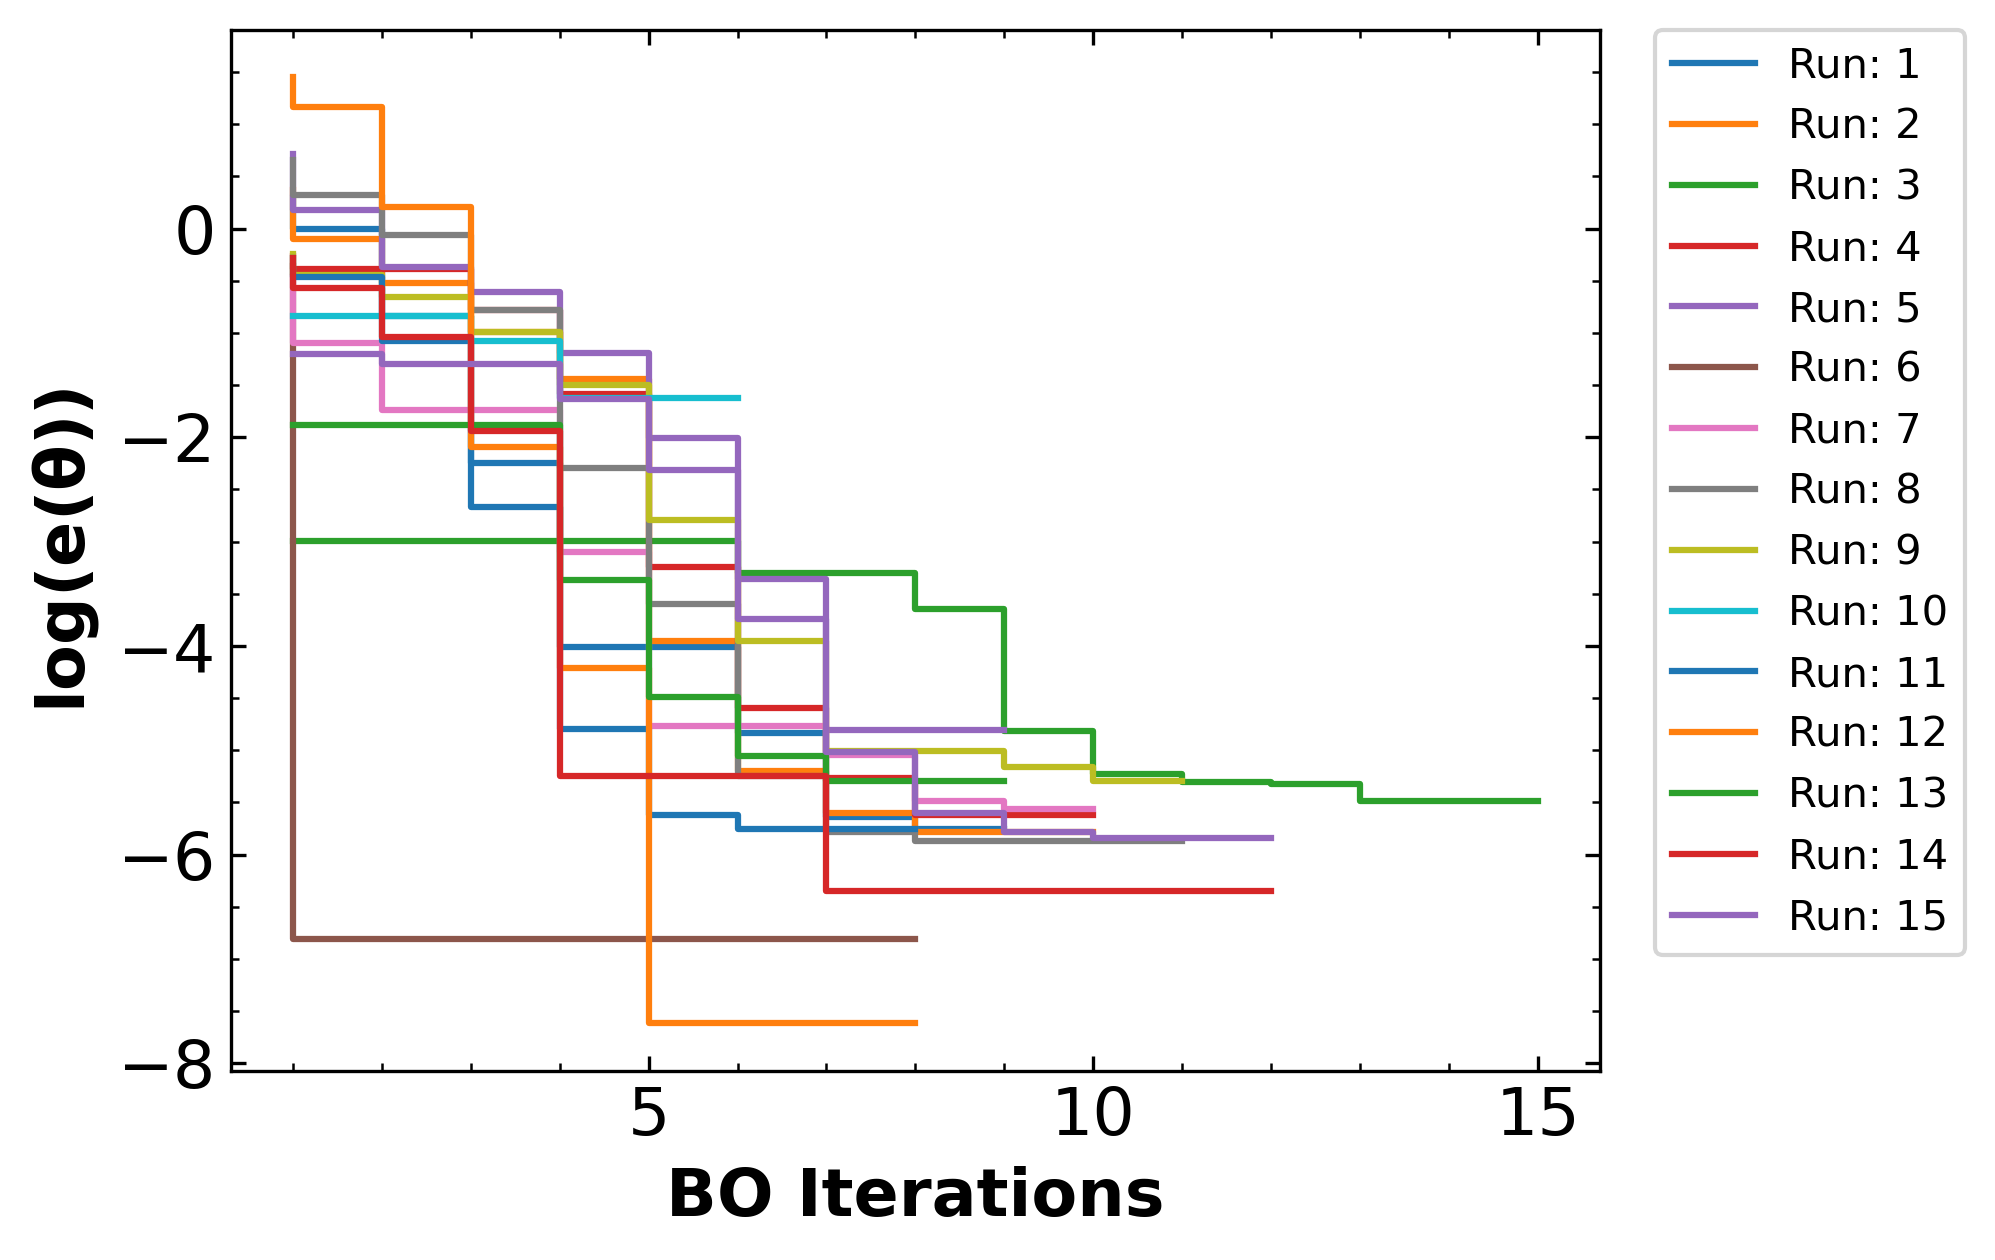

In [7]:
#WORKS
csv_end = ".csv" #For obj
fxn = "plot_obj_abs_min"

path = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo = None, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = ".csv")
# print(path)
obj_abs_min = csv_to_array(path)
plot_obj_abs_min(obj_abs_min, emulator, ep, sparse_grid, set_lengthscale, t, obj,
                 save_figure, tot_iter, tot_runs,DateTime, sep_fact, save_CSV = save_CSV)

In [8]:
#WORKS
# save_figure = True
Theta_array = []

fxn = "plot_Theta"
for i in range(len(param_dict.keys())):
    csv_end = "/"+param_dict[i]+ ".csv" #For Thetas #Need to ensure this saves correctly

    path_i = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo = None, bo_iter= None, 
              title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                     sep_fact = sep_fact, is_figure = is_figure, csv_end = csv_end)
    Theta_array.append( csv_to_array(path_i) )

Theta_array = np.array(Theta_array).T

plot_Theta(Theta_array, Theta_True, t, obj, ep, emulator, sparse_grid,  set_lengthscale, save_figure, 
           param_dict, tot_iter, tot_runs, DateTime, sep_fact = sep_fact)

FileNotFoundError: [Errno 2] No such file or directory: '2022/10/21/13-18/CSV_Data/Convergence_Figs/GP_Emulator/Sparse/TP_100/obj/ep_1.0/len_scl_varies/Sep_Fact_0.7/Total_Runs_15/Param_Conv/\\theta_1.csv'

In [ ]:
#WORKS
# save_figure = True
nbins = 10

Theta_array = []

fxn = "plot_Theta_min"
for i in range(len(param_dict.keys())):
    csv_end = "/"+param_dict[i]+ ".csv" #For Thetas #Need to ensure this saves correctly

    path_i = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo = None, bo_iter= None, 
              title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                     sep_fact = sep_fact, is_figure = is_figure, csv_end = csv_end)
    Theta_array.append( csv_to_array(path_i) )

Theta_array = np.array(Theta_array).T

plot_Theta_min(Theta_array, Theta_True, t, obj, ep, emulator, sparse_grid, set_lengthscale, save_figure, 
           param_dict, tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, nbins = nbins, save_CSV = save_CSV)

In [ ]:
fxn = "plot_org_train"
save_figure = False

path_train = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj,  mesh_combo, bo_iter=None, title_save = None, run = run, 
                       tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, 
                       csv_end = "/" + "train_theta.csv")
path_test = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, bo_iter=None, title_save = None, run = run, 
                       tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, 
                       csv_end = "/" + "test_theta.csv")
fxn = "value_plotter"
path_true = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, mesh_combo, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + "True_p.csv")

train_p = csv_to_array(path_train)
test_p = csv_to_array(path_test)
true_p = csv_to_array(path_true)
plot_org_train(theta_mesh,train_p, test_p, true_p, Xexp, emulator, sparse_grid, obj, ep, set_lengthscale, run, save_figure, param_names_list, 
               tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, verbose = True, sep_fact = sep_fact)